# 03 - Model Evaluation and Business Recommendation

This notebook compares trained models, visualizes performance, tunes threshold for recall target, and recommends a production candidate.

In [1]:
import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)

import sys
import os
os.getcwd()
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'Data').exists() and (p / 'requirements.txt').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


def load_model(path):
    return joblib.load(Path(path))


def find_threshold_for_target_recall(y_true, y_scores, min_recall=0.75):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    valid = np.where(recall[:-1] >= min_recall)[0]
    if len(valid) == 0:
        return 0.5, float(precision[-1]), float(recall[-1])
    idx = valid[np.argmax(precision[valid])]
    return float(thresholds[idx]), float(precision[idx]), float(recall[idx])

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 100)


In [ ]:
# Validate project layout (helps avoid Colab path issues)
required_dirs = ['Data', 'Models', 'Visualizations', 'Report']
missing_dirs = [d for d in required_dirs if not (PROJECT_ROOT / d).exists()]
required_files = ['requirements.txt', 'Data/german_credit_data.csv']
missing_files = [f for f in required_files if not (PROJECT_ROOT / f).exists()]

if missing_dirs or missing_files:
    raise FileNotFoundError(
        'PROJECT_ROOT check failed. '        f'PROJECT_ROOT={PROJECT_ROOT}; '        f'missing_dirs={missing_dirs}; '        f'missing_files={missing_files}'
    )

print('Project layout OK:', PROJECT_ROOT)


## 1. Load Test Data and Models

In [4]:
X_test = pd.read_csv(PROJECT_ROOT / 'Data/X_test.csv')
y_test = pd.read_csv(PROJECT_ROOT / 'Data/y_test.csv')['Risk']

model_paths = {
    'logistic_regression': PROJECT_ROOT / 'Models/logistic_regression.pkl',
    'decision_tree': PROJECT_ROOT / 'Models/decision_tree.pkl',
    'random_forest': PROJECT_ROOT / 'Models/random_forest.pkl',
    'xgboost': PROJECT_ROOT / 'Models/xgboost.pkl',
}


models = {name: load_model(path) for name, path in model_paths.items()}
print('Loaded models:', list(models.keys()))


Loaded models: ['logistic_regression', 'decision_tree', 'random_forest', 'xgboost']
X_test shape: (200, 13)


## 2. Evaluate All Models

In [5]:
def evaluate_model_full(model, X, y_true):
    y_pred = model.predict(X)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X)[:, 1]
    else:
        y_score = y_pred

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_true, y_score),
    }, y_pred, y_score

all_metrics = {}
predictions = {}
scores = {}

for name, model in models.items():
    metrics, y_pred, y_score = evaluate_model_full(model, X_test, y_test)
    all_metrics[name] = metrics
    predictions[name] = y_pred
    scores[name] = y_score

comparison_df = pd.DataFrame(all_metrics).T.sort_values(['Recall', 'F1-Score'], ascending=False)
comparison_df

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
logistic_regression,0.815,0.705128,0.797101,0.748299,0.904304
xgboost,0.890,0.912281,0.753623,0.825397,0.947118
random_forest,0.840,0.893617,0.608696,0.724138,0.910886
decision_tree,0.780,0.719298,0.594203,0.650794,0.736033


## 3. Confusion Matrices (All Models)

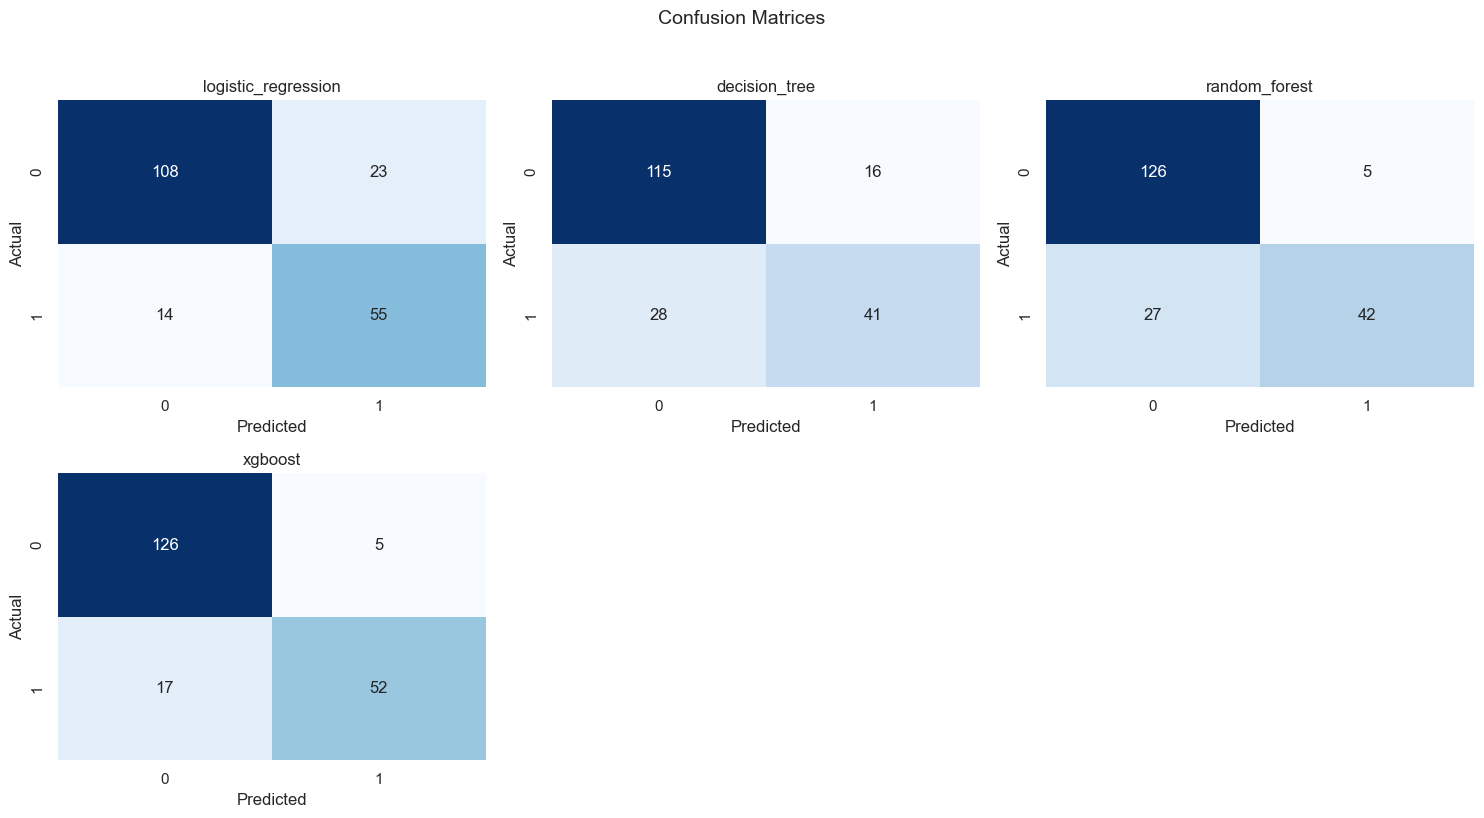

In [6]:
n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).reshape(-1)

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Confusion Matrices', y=1.02, fontsize=14)
plt.tight_layout()
(PROJECT_ROOT / 'Visualizations').mkdir(parents=True, exist_ok=True)
plt.savefig(PROJECT_ROOT / 'Visualizations/confusion_matrices_all_models.png', dpi=150, bbox_inches='tight')


## 4. ROC Curves (All Models)

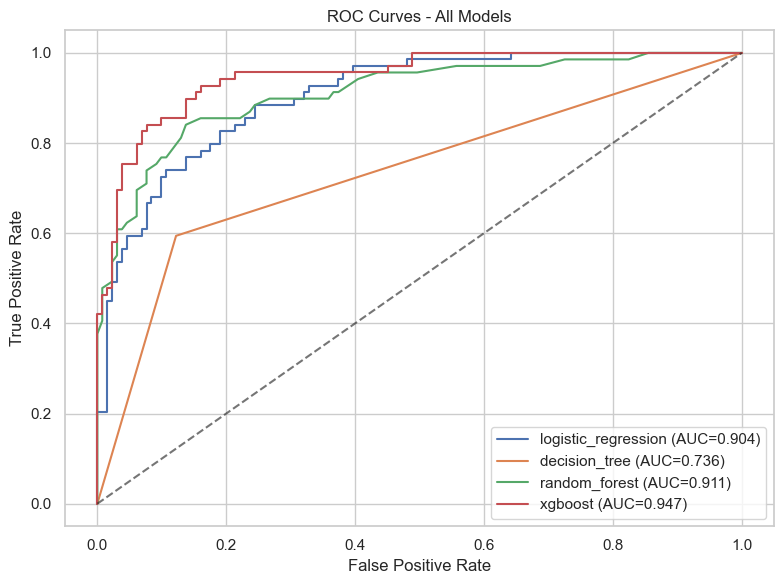

In [7]:
plt.figure(figsize=(8, 6))
for name, y_score in scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'Visualizations/roc_curves_all_models.png', dpi=150, bbox_inches='tight')


## 5. Feature Importance (Tree-Based Models)

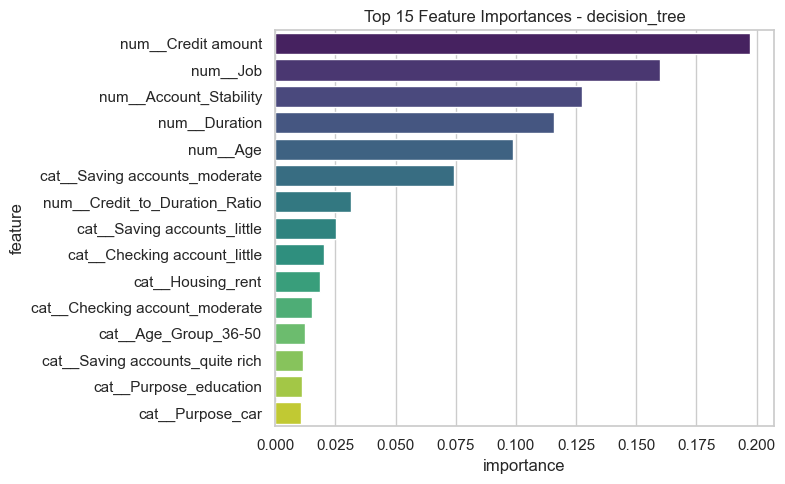

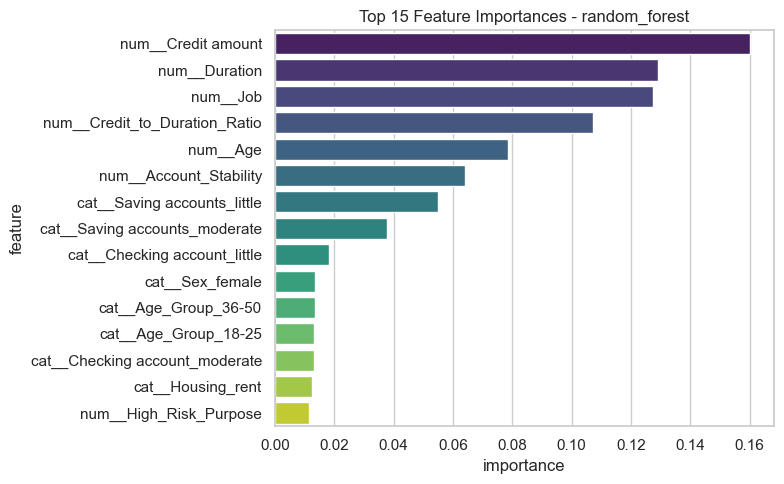

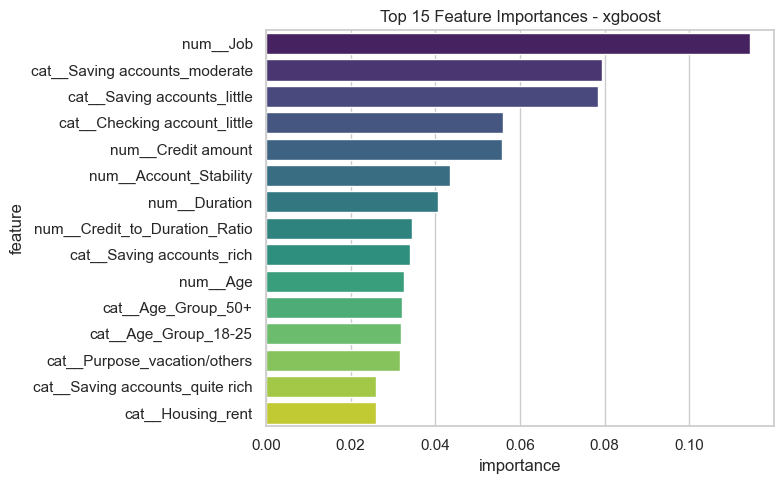

In [8]:
tree_model_keys = [k for k in models.keys() if 'tree' in k or 'forest' in k or 'xgboost' in k]

for name in tree_model_keys:
    model = models[name]
    clf = model.named_steps['classifier']

    if not hasattr(clf, 'feature_importances_'):
        continue

    preprocessor = model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    importances = clf.feature_importances_

    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
    plt.title(f'Top 15 Feature Importances - {name}')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'Visualizations' / f'feature_importance_{name}.png', dpi=150, bbox_inches='tight')


## 6. Precision-Recall Curve and Threshold Tuning (Best Recall Model)

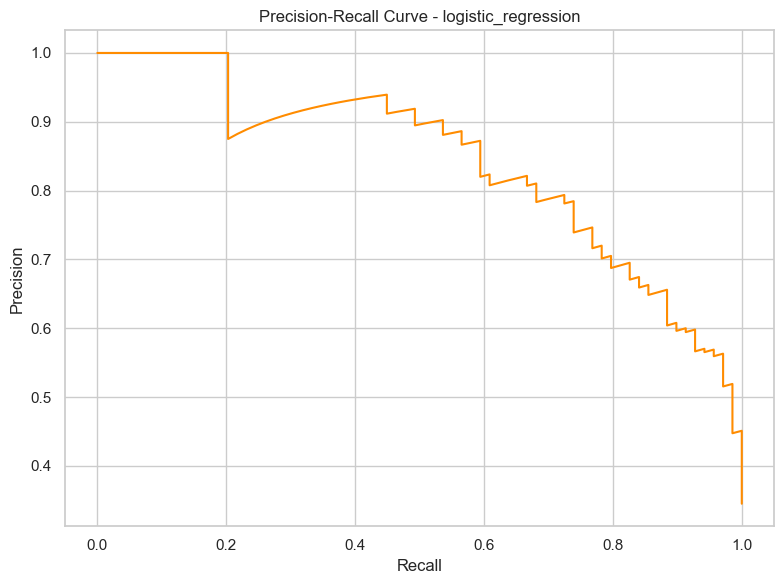

Best model by ranking: logistic_regression
Recommended threshold for recall>=0.75: 0.5833
Expected precision at threshold: 0.7465
Expected recall at threshold: 0.7681


In [9]:
best_model_name = comparison_df.index[0]
best_model = models[best_model_name]
best_scores = scores[best_model_name]

precision, recall, thresholds = precision_recall_curve(y_test, best_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'Visualizations/precision_recall_best_model.png', dpi=150, bbox_inches='tight')
plt.show()

threshold, tuned_precision, tuned_recall = find_threshold_for_target_recall(
    y_true=y_test,
    y_scores=best_scores,
    min_recall=0.75,
)

print(f'Best model by ranking: {best_model_name}')
print(f'Recommended threshold for recall>=0.75: {threshold:.4f}')
print(f'Expected precision at threshold: {tuned_precision:.4f}')


## 7. Business Interpretation

In [10]:
print('1) Most important metric: Recall for default class (bad).')
print('   Reason: Missing an actual defaulter (false negative) directly increases credit loss.')

print('2) False Negative vs False Positive cost:')
print('   - False Negative (predict good, actually bad): High financial risk due to loan default.')
print('   - False Positive (predict bad, actually good): Opportunity cost from rejecting good customers.')

print('3) Production recommendation:')
print('   - Use threshold-tuned model meeting recall >= 0.75, then optimize precision subject to that constraint.')

1) Most important metric: Recall for default class (bad).
   Reason: Missing an actual defaulter (false negative) directly increases credit loss.
2) False Negative vs False Positive cost:
   - False Negative (predict good, actually bad): High financial risk due to loan default.
   - False Positive (predict bad, actually good): Opportunity cost from rejecting good customers.
3) Production recommendation:
   - Use threshold-tuned model meeting recall >= 0.75, then optimize precision subject to that constraint.


## 8. Save Evaluation Outputs

In [ ]:
comparison_df.to_csv(PROJECT_ROOT / 'Report/model_evaluation_comparison.csv', index=True)

summary = pd.DataFrame([
    {
        'selected_model': best_model_name,
        'threshold_for_recall_0_75': threshold,
        'precision_at_threshold': tuned_precision,
        'recall_at_threshold': tuned_recall,
    }
])
summary.to_csv(PROJECT_ROOT / 'Report/production_threshold_recommendation.csv', index=False)

print('Saved evaluation outputs to Report/.')
